# Data Clean up
Updated on: 2022-08-04 20:02:31 CEST

Authors: Abzer Kelminal (abzer.shah@uni-tuebingen.de) <br>
Input file format: .csv files or .txt files <br>
Outputs: .csv files  <br>
Dependencies: ggplot2, dplyr, IRdisplay

This Notebook is used for cleaning the feature table, an output of metabolomics experiment, containing all the features with their corresponding intensities. The data cleanup steps involved are: 1) Blank removal 2) Imputation 3) Normalisation. Each step would be discussed in detail later.

<div class="alert alert-block alert-warning">
    
Kindly download this Jupyter Notebook and run it in your local computer for successful running of the code. To know more about how to get the Jupyter Notebook running with R code, please have a look at this document: [GitHub Link](https://github.com/Functional-Metabolomics-Lab/Jupyter-Notebook-Installation/blob/main/Anaconda%20with%20R%20kernel%20installation.pdf)
    
    
<b><font size=3> SPECIAL NOTE: Please read the comments before proceeding with the code and let us know if you run into any errors and if you think it could be commented better. We would highly appreciate your suggestions and comments!!</font> </b> </div>

# Test data for Non-Targeted Metabolomics Summer School:
<div class="alert alert-block alert-success"> 
<p style='text-align: justify;'> 
Samples and data where generated by Jeffrey Hawkees, Carsten Simon and Daniel Petras. The samples contain marine dissolved organic matter (M) with different levels of algae metabolites (A). We will use M, A5M, A15M and A45M as test data.
</p>
</div>

# Package installation:

In [45]:
#installing and calling the necessary packages:
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("dplyr")) install.packages("dplyr")
if (!require("IRdisplay")) install.packages("IRdisplay")

library(ggplot2)
library(dplyr)
library(IRdisplay)

# Getting the input files:

## 1) Reading the input data using URL (from GitHub):
Here, we can directly pull the data files from our Functional Metabolomics Github page:

In [48]:
## Non-gap filled
nft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/MZmine/DOM_InterLab_NonGapFilled_quant.csv'
## Gap filled
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/MZmine/DOM_Interlab_GapFilled_quant.csv'
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/metadata_lab15.txt'

In [49]:
nft <- read.csv(nft_url, header = T, check.names = F)
ft <- read.csv(ft_url, header = T, check.names = F)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

## 2) Setting a local working directory and creating an automatic result directory:
<p style='text-align: justify;'> <font color='green'> <b> MAKE SURE TO INCLUDE ALL THE INPUT FILES IN ONE FOLDER.</b> Setting a local working directory works well with Jupyter Notebook. If you are working with Jupyter Notebook, you can simply copy the folder path of your input files from your local computer to the output line of the next cell. It will be set as your working directory (or working folder)  </font></p> 
<p style='text-align: center;'>For ex: D:\User\Project\Test_Data </p> 

In [50]:
# setting the current directory as the working directory
Directory <- normalizePath(readline("Enter the path of the folder with input files: "),"/",mustWork=FALSE)
setwd(Directory)

Enter the path of the folder with input files: D:\Projects\20220802_TestData_Summerschool\data


In [51]:
getwd() #to get the working directory 

[1] "D:/Projects/20220802_TestData_Summerschool/data"

<p style='text-align: justify;'> <font color='red'> <b> For Google Collab, it is not possible to access the files from your local computer as it is hosted on Google's cloud server. An easier workaround is to upload the necessary files into the Google colab session using the 'Files' icon on the left. The code below creates a new folder 'My_TestData' in the Colab space and sets the folder as working directory. </b> </font> </p>

![Google-Colab Files Upload](https://github.com/abzer005/Images-for-Jupyter-Notebooks/blob/main/StepsAll.png?raw=true)

In [ ]:
#Only for Google Colab:
dir.create("/content/My_TestData", showWarnings = TRUE, recursive = FALSE, mode = "0777")
setwd("/content/My_TestData")

<p style='text-align: justify;'> <font color='red'> Now, we can upload our files from our local PC to the folder 'My_TestData' and continue with the rest of the script. </font> </p>
<p style='text-align: justify;'> <font color='red'> <b> SPECIAL NOTE: All the files uploaded to Google Colab would generally disappear after 12 hours. Similarly, all the outputs would be saved in the Colab and we need to download them into our local system at the end of our session. </b> </font> </p>

In [53]:
# Getting all the files in the folder
dirs <- dir(path=paste(getwd(), sep=""), full.names=TRUE, recursive=TRUE)
folders <- unique(dirname(dirs))
files <- list.files(folders, full.names=TRUE)
files_1 <- basename((files))
files_2 <- dirname((files))
# Creating a Result folder
dir.create(path=paste(files_2[[1]], "_Results", sep=""), showWarnings = TRUE)
fName <-paste(files_2[[1]], "_Results", sep="")

IRdisplay::display(data.frame(INDEX=c(1:length(files_1)),Filename=files_1))

Warning message in dir.create(path = paste(files_2[[1]], "_Results", sep = ""), :
"'D:\Projects\20220802_TestData_Summerschool\data_Results' already exists"

INDEX,Filename
1,DOM_Interlab_GapFilled.mgf
2,DOM_Interlab_GapFilled_quant.csv
3,DOM_InterLab_NonGapFilled.mgf
4,DOM_InterLab_NonGapFilled_quant.csv
5,metadata_lab15.txt


In the following line, enter the required file index numbers separated by commas. For example as: 1,2,3. The accepted file formats are csv,txt and tsv.

In [54]:
input <- as.double(unlist(strsplit(readline("Specify the file index of gapfilled feature-file, metadata separated by commas:"), split=",")))

#Gets the extension of each file. Ex:csv
pattern <- c()
for (i in files_1){
  sep_file <- substr(i, nchar(i)-2,nchar(i))
  pattern <- rbind(pattern,sep_file)
}
#pattern

ft <- read.csv(files_1[input[1]],sep = ifelse(pattern[input[1]]!="csv","\t",","), header=TRUE,check.names = FALSE) # By applying 'row.names = 1', the 1st column 'ID' becomes the row names
md <-read.csv(files_1[input[2]], sep = ifelse(pattern[input[2]]!="csv","\t",","), header=TRUE,check.names = FALSE)

Specify the file index of gapfilled feature-file, metadata separated by commas:2,5


<p style='text-align: justify;'> Since non gapfilled feature file is not a direct output of mzMine, not everybody will have it. Therefore, we have the next cell separately. For the imputation step, we can also impute the feature table without a non-gapfilled feature file.</p>

 More about this in the later section: [Imputation with a Cutoff LOD](#Impute_LOD)

In [55]:
#If you have non gapfilled feature file:
if(readline("Do you have non gap-filled feature table? Y/N:")=="Y"){
  x <- as.double(readline("Enter the ID number of non-gap-filled feature file:"))
  nft<- read.csv(files_1[x],sep=ifelse(pattern[x]!="csv","\t",","), header = TRUE,check.names = FALSE)
}

Do you have non gap-filled feature table? Y/N:Y
Enter the ID number of non-gap-filled feature file:4


Lets check if the data has been read correclty!!

In [56]:
head(ft)
dim(ft)

row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,...,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML Peak area,
39899,150.1277,15.915050,NA,NA,NA,NA,NA,NA,NA,...,309798.80,301694.75,275795.66,299175.80,276375.80,297763.12,294452.34,310736.38,271224.75,NA
725,152.0707,3.252315,NA,NA,NA,NA,NA,NA,NA,...,65684.95,59132.38,63070.29,75374.20,77477.00,76915.33,73175.08,72739.46,75286.51,NA
1105,152.1070,4.733518,NA,NA,NA,NA,NA,NA,NA,...,12656.36,14726.92,20211.17,27020.12,30656.02,34365.83,47937.98,48518.27,53590.48,NA
39939,152.9950,16.092033,NA,NA,NA,NA,NA,NA,NA,...,50093.42,60120.45,74337.16,86491.50,69883.56,49851.19,78858.71,80752.22,79900.84,NA
21233,153.0910,8.525323,NA,NA,NA,NA,NA,NA,NA,...,224237.86,191593.34,225893.94,225190.95,236631.94,237659.23,136346.10,143093.28,177747.20,NA
39885,153.1386,15.877678,NA,NA,NA,NA,NA,NA,NA,...,463830.22,519151.22,421785.75,438362.40,403150.34,422956.78,450506.53,460547.80,398762.47,NA


[1] 5020   30

In [57]:
head(nft)
dim(nft)

row ID,row m/z,row retention time,row ion mobility,row ion mobility unit,row CCS,correlation group ID,annotation network number,best ion,auto MS2 verify,...,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML Peak area,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML Peak area,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML Peak area,
39899,150.1277,15.915050,NA,NA,NA,NA,NA,NA,NA,...,309798.80,301694.75,275795.66,299175.80,276375.80,297763.12,294452.34,310736.38,271224.75,NA
725,152.0707,3.252315,NA,NA,NA,NA,NA,NA,NA,...,65684.95,59132.38,63070.29,75374.20,77477.00,76915.33,73175.08,72739.46,75286.51,NA
1105,152.1070,4.737268,NA,NA,NA,NA,NA,NA,NA,...,0.00,0.00,0.00,27020.12,30656.02,34365.83,47937.98,48518.27,53590.48,NA
39939,152.9951,16.092170,NA,NA,NA,NA,NA,NA,NA,...,0.00,0.00,74337.16,86491.50,69883.56,0.00,78858.71,80752.22,79900.84,NA
21233,153.0910,8.525323,NA,NA,NA,NA,NA,NA,NA,...,224237.86,191593.34,225893.94,225190.95,236631.94,237659.23,136346.10,143093.28,177747.20,NA
39885,153.1386,15.877678,NA,NA,NA,NA,NA,NA,NA,...,463830.22,519151.22,421785.75,438362.40,403150.34,422956.78,450506.53,460547.80,398762.47,NA


[1] 5020   30

In [58]:
head(md)
dim(md)

filename,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15
DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,A15M,Sample,15
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,A45M,Sample,45
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,A45M,Sample,45
DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,A45M,Sample,45


[1] 16  4

<p style='text-align: justify;'> In the next cell, we are trying to bring the feature table and metadata in the correct format such as the rownames of metadata and column names of feature table are the same. They both are the file names and they need to be the same, as from now on, we will call the columns in our feature table based on our metadata information. Thus, using the metadata, the user can filter their data easily. You can also directly deal with your feature table without metadata by getting your hands dirty with some coding!! But having a metadata improves the user-experience greatly. </p>

In [59]:
#Removing Peak area extensions
colnames(ft) <- gsub(' Peak area','',colnames(ft))
md$filename<- gsub(' Peak area','',md$filename)

#Removing if any NA columns present in the md file
md <- md[,colSums(is.na(md))<nrow(md)]

#Changing the row names of the files
rownames(md) <- md$filename
md <- md[,-1]
rownames(ft) <- paste(ft$'row ID',round(ft$'row m/z',digits = 3),round(ft$'row retention time',digits = 3), sep = '_')

#Picking only the files with column names containing 'mzML'
ft <- ft[,grep('mzML',colnames(ft))]

# if nft file exists, we perform all the above for nft as well
if(exists("nft")==T){
    colnames(nft) <- gsub(' Peak area','',colnames(nft))
    rownames(nft) <- paste(nft$'row ID',round(nft$'row m/z',digits = 3),round(nft$'row retention time',digits = 3), sep = '_')
    nft <- nft[,grep('mzML',colnames(nft))]
}

In [60]:
new_ft<- ft[,order(colnames(ft))] #ordering the ft by its column names
new_md <-md[order(rownames(md)),] #ordering the md by its row names

#lists the colnames(ft) which are not present in md
unmatched_ft <- colnames(new_ft)[which(is.na(match(colnames(new_ft),rownames(new_md))))] 
cat("These", length(unmatched_ft),"columns of feature table are not present in metadata:")
if((length(unmatched_ft) %% 2) ==0)
{matrix(data=unmatched_ft,nrow=length(unmatched_ft)/2,ncol=2)}else
{matrix(data=unmatched_ft,nrow=(length(unmatched_ft)+1)/2,ncol=2)}

flush.console()
Sys.sleep(0.2)

#lists the rownames of md which are not present in ft
unmatched_md <- rownames(new_md)[which(is.na(match(rownames(new_md),colnames(new_ft))))] 
cat("These", length(unmatched_md),"rows of metadata are not present in feature table:")
if((length(unmatched_md) %% 2) ==0)
{matrix(data=unmatched_md,nrow=length(unmatched_md)/2,ncol=2)}else
{matrix(data=unmatched_md,nrow=(length(unmatched_md)+1)/2,ncol=2)}

#Removing those unmatching columns and rows:
if(length(unmatched_ft)!=0){new_ft <- subset(ft, select = -c(which(is.na(match(colnames(ft),rownames(md))))) )}
if(length(unmatched_md)!=0){new_md <- md[-c(which(is.na(match(rownames(md),colnames(ft))))),]}

These 0 columns of feature table are not present in metadata:

[,1] [,2]

These 0 rows of metadata are not present in feature table:

[,1] [,2]

In [61]:
#checking the dimensions of our new ft and md:
cat("The number of rows and columns in our original ft is:",dim(ft),"\n")
cat("The number of rows and columns in our new ft is:",dim(new_ft),"\n")
cat("The number of rows and columns in our new md is:",dim(new_md))

The number of rows and columns in our original ft is: 5020 16 
The number of rows and columns in our new ft is: 5020 16 
The number of rows and columns in our new md is: 16 3

Notice that the number of columns of feature table is same as the number of rows in our metadata. Now, we have both our feature table and metadata in the same order.

In [62]:
new_ft<- new_ft[,order(colnames(new_ft))] #ordering the ft by its column names
new_md <-new_md[order(rownames(new_md)),] #ordering the md by its row names
#checking if they are the same
if(identical(colnames(new_ft),rownames(new_md))==T)
   {print("The column names of ft and rownames of md are the same")}else{print("The column names of ft and rownames of md are not the same")}

[1] "The column names of ft and rownames of md are the same"


Lets check the files once again!!

In [ ]:
head(nft)
dim(nft)

In [ ]:
head(new_ft)
dim(new_ft)

In [ ]:
head(md)
dim(md)

# Splitting the data into Blanks and Samples using Metadata:
<a id="data_split"></a>

For the first step: Blank removal, we need to split the data as spectra obtained from blanks and samples respectively using the metadata. More about Blank removal in the next section.

Let's call the metadata and feature table in different names so that we don't change the original files.

In [18]:
Meta_Filter <- md
input_data <- new_ft

From the below cell output, we get an idea of the multiple levels in each of the metioned attributes in the metadata

In [19]:
 lev <- c()
  for(i in 1:ncol(Meta_Filter)){
    x <- levels(as.factor(Meta_Filter[,i]))
    if(is.double(Meta_Filter[,i])==T){x=round(as.double(x),2)}
    x <-toString(x)
    lev <- rbind(lev,x)
  }

Info_mat <- data.frame(INDEX=c(1:ncol(Meta_Filter)),ATTRIBUTES=colnames(Meta_Filter),LEVELS=lev,row.names=NULL)
Info_mat

INDEX,ATTRIBUTES,LEVELS
1,ATTRIBUTE_Sample,"A, A15M, A45M, A5M, M, PPL"
2,ATTRIBUTE_Sample_Type,"Process_Blank, Sample"
3,ATTRIBUTE_Time-Point,"0, 5, 15, 45, 100"


### Subsetting the dataset:

In case of having several groups in our data, for ex: different species like B.sub and E.coli, we can subset the data accordingly using the next cell. In our case, we are not subsetting the data 

In [63]:
#Splitting batch-wise:
Batch_info <- ifelse(readline("Do you want to subset your data? Y/N: ")=="Y",as.double(readline("Please enter the index of the attributes having information of different groups:")),"No")
if(is.numeric(Batch_info)==TRUE){
    Levels_Batch <- levels(as.factor(Meta_Filter[,Batch_info]))
    IRdisplay::display(data.frame(INDEX=c(1:length(Levels_Batch)),LEVELS=Levels_Batch))
    
    flush.console()  
    Sys.sleep(0.2)
    
    Cdtn <-as.double(unlist(strsplit(readline("Enter the index number of condition(s) you want to KEEP (separated by commas):"), split=',')))
    
    #Getting all the rows of metadata that satisfies each element of the condition and storing it as an element in Split_data list
    Split_data <-list()
    for (j in 1:length(Cdtn)){
      Split_data[[j]] <- Meta_Filter[(Meta_Filter[,Batch_info]==Levels_Batch[Cdtn[j]]),]
    }
    
    Batch_data <-do.call(rbind, Split_data) # unlists the Split data and combines them by row
    flush.console()  
    Sys.sleep(0.2)
   
    IRdisplay::display(head(Batch_data)) #Visualising the Batch_data
    dim(Batch_data)
    }

Do you want to subset your data? Y/N: N


Once we subset the data according to a batch, we can further proceed to split the blanks from the sample in the cell below. If no batch data is present, you can simply split your metadata into blank and sample.

In [64]:
#If batch data exists, it will take it as "data", else take Meta_filter as "data"
if(exists("Batch_data")==T){data <-Batch_data}else{data <-Meta_Filter}

Info_mat
Condition <- as.double(unlist(readline("Enter the index number of the attribute to split sample and blank:")))

Levels_Cdtn <- levels(as.factor(data[,Condition[1]]))
print(matrix(Levels_Cdtn,length(Levels_Cdtn)))
 
  #Among the shown levels of an attribute, select the ones to keep
Blk_id <- as.double(unlist(readline("Enter the index number of your BLANK:")))
paste0('You chosen blank is:',Levels_Cdtn[Blk_id])
  
  #Splitting the data into blanks and samples based on the metadata
md_Blank <- data[(data[,Condition] == Levels_Cdtn[Blk_id]),]
Blank <- input_data[,which(colnames(input_data)%in%rownames(md_Blank)),drop=F] 
md_Samples <- data[(data[,Condition] != Levels_Cdtn[Blk_id]),]
Samples <- input_data[,which(colnames(input_data)%in%rownames(md_Samples)),drop=F] 

INDEX,ATTRIBUTES,LEVELS
1,ATTRIBUTE_Sample,"A, A15M, A45M, A5M, M, PPL"
2,ATTRIBUTE_Sample_Type,"Process_Blank, Sample"
3,ATTRIBUTE_Time-Point,"0, 5, 15, 45, 100"


Enter the index number of the attribute to split sample and blank:2
     [,1]           
[1,] "Process_Blank"
[2,] "Sample"       
Enter the index number of your BLANK:1


[1] "You chosen blank is:Process_Blank"

In [65]:
head(Blank)
dim(Blank)

,DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML
39899_150.128_15.915,314479.1
725_152.071_3.252,0.0
1105_152.107_4.734,0.0
39939_152.995_16.092,109217.7
21233_153.091_8.525,0.0
39885_153.139_15.878,629542.8


[1] 5020    1

In [66]:
head(Samples)
dim(Samples)

,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
39899_150.128_15.915,341852.47,319392.25,328367.00,299175.80,297763.12,276375.80,294452.34,310736.38,271224.75,301694.75,289554.88,275795.66,311834.800,309798.80,294450.00
725_152.071_3.252,0.00,0.00,0.00,75374.20,76915.33,77477.00,73175.08,72739.46,75286.51,59132.38,62091.97,63070.29,54793.090,65684.95,65077.08
1105_152.107_4.734,73926.81,75761.62,79481.29,27020.12,34365.83,30656.02,47937.98,48518.27,53590.48,14726.92,13063.94,20211.17,9119.948,12656.36,10552.45
39939_152.995_16.092,98328.55,80933.12,82629.68,86491.50,49851.19,69883.56,78858.71,80752.22,79900.84,60120.45,62739.87,74337.16,82283.310,50093.42,55542.06
21233_153.091_8.525,0.00,0.00,0.00,225190.95,237659.23,236631.94,136346.10,143093.28,177747.20,191593.34,167290.80,225893.94,216016.230,224237.86,235601.08
39885_153.139_15.878,538539.56,518349.44,499826.44,438362.40,422956.78,403150.34,450506.53,460547.80,398762.47,519151.22,460812.72,421785.75,474049.940,463830.22,465346.20


[1] 5020   15

# Creating a function named FrequencyPlot:  
The below function takes the two input datatables: for example, gapfilled and non-gapfilled as its inputs, calculates the frequency distribution of the data in the order of 10 and produces a grouped barplot showing the distribution as output. The frequency plot shows where the features are present in higher number.

In [67]:
#'Global' settings for plot size in the output cell
#options(repr.plot.width=10, repr.plot.height=8,res=600) #For google collab
options(repr.plot.width=5, repr.plot.height=3) #For Jupyter Notebook

In [68]:
FrequencyPlot <- function(x1,x2){
  
   #creating bins from -1 to 10^10 using sequence function seq()
    bins <- c(-1,0,(1 * 10^(seq(0,10,1)))) 
    
    #cut function cuts the give table into its appropriate bins
    scores_x1 <- cut(as.matrix(x1),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10')) 
    
    #transform function convert the tables into a column format: easy for visualization 
    Table_x1<-transform(table(scores_x1)) #contains 2 columns: "scores_x1", "Freq"
    
    #Repeating the same steps for x2
    scores_x2 <- cut(as.matrix(x2),bins,labels = c('0','1','10','1E2','1E3','1E4','1E5','1E6','1E7','1E8','1E9','1E10'))
    Table_x2<-transform(table(scores_x2))
  
    #Getting the names of x1 and x2
    arg1 <- deparse(substitute(x1))
    arg2 <-deparse(substitute(x2))
    
    #Creating a data frame for plotting
    data_plot <- as.data.frame(c(Table_x1$Freq,Table_x2$Freq)) #Concatenating the frequency info of both tables rowwise
    colnames(data_plot) <- "Freq" #naming the 1st column as 'Freq'
    data_plot$Condition <- c(rep(arg1,12),rep(arg2,12)) #adding a 2nd column 'Condition', which just repeats the name of x1 and x2 accordingly
    data_plot$Range_bins <- rep(Table_x1$scores_x1,2) #Adding 3rd column 'Range Bins'
    data_plot$Log_Freq <- log(data_plot$Freq+1) #Log scaling the frequency values
    
    ## GGPLOT2
    BarPlot <- ggplot(data_plot, aes(Range_bins, Log_Freq, fill = Condition)) + 
    geom_bar(stat="identity", position = "dodge", width=0.4) + 
    scale_fill_brewer(palette = "Set1") +
    ggtitle(label="Frequency plot") +
    xlab("Range") + ylab("(Log)Frequency") + labs(fill = "Data Type") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +   # setting the angle for the x label
    theme(axis.text.y = element_text(angle = 45, vjust = 0.5, hjust=1)) +   # setting the angle for the y label
    theme(plot.title = element_text(hjust = 0.5)) # centering the plot title
  
    print(BarPlot)
}  

<p style='text-align: justify;'> As you have noticed, the above cell didn't produce any outputs. Here, we created our own function called 'FrequencyPlot'. which works similar to "FREQUENCY" function in MS Excel. Here, we have also added codes to print a nice ggplot as ouput of our function. Hence, like 'print' function prints an output, whenever we use our 'FrequencyPlot' function with the input variables, it will produce an output plot using the calculation in the above cell. </p>

**Now that we have our data ready, we can start with the cleanup steps!!**

# Step1: Blank Removal

<p style='text-align: justify;'> In LC-MS/MS, we use solvents called Blanks which are usually injected time-to-time to prevent carryover of the sample. The features coming from these Blanks would also be detected by LC-MS/MS instrument. Our goal here is to remove these features from our samples. The other blanks that can be removed are: Signals coming from growth media alone in terms of microbial growth experiment, signals from the solvent used for extraction methods and so on. Therefore, it is best practice to measure mass spectra of these blanks as well in addition to your sample spectra. </p>

**How do we remove these blank features?** </br> 
<p style='text-align: justify;'> Since we have the feature table split into Control blanks and Sample groups now, we can compare blanks to the sample to identify the background features coming from blanks. A common filtering method is to use a cutoff to remove features that are not present sufficient enough in our biological samples. </p>

The steps followed in the next few cells are:
1. <p style='text-align: justify;'> We find an average for all the feature intensities in your blank set and sample set. Therefore, for n no.of features in a blank or sample set, we get n no.of averaged features. </p>
2. <p style='text-align: justify;'> Next, we get a ratio of this average_blanks vs average_sample. This ratio Blank/sample tells us how much of that particular feature of a sample gets its contribution from blanks. If it is more than 30% (or Cutoff as 0.3), we consider the feature as noise. </p>
3. <p style='text-align: justify;'> The resultant information (if ratio > Cutoff or not) is stored in a bin such as 1 = Noise or background signal, 0 = Feature Signal</p>
4. <p style='text-align: justify;'> We count the no.of features in the bin that satisfies the condition ratio > cutoff, and consider those features as 'noise or background features' and remove them. </p>

For a dataset containing several batches or groups, the filtering steps are performed group-wise and it can be done using the previous section [Subsetting the dataset](#data_split)

**<font color='red'> The Cutoff used to obtain the all the files in MZmine Results folder is 0.3 </font>**

In [69]:
if(readline('Do you want to perform Blank Removal- Y/N:')=='Y'){
    
    #When cutoff is low, more noise (or background) detected; With higher cutoff, less background detected, thus more features observed
    Cutoff <- as.numeric(readline('Enter Cutoff value between 0.1 & 1:')) # (i.e. 10% - 100%). Ideal cutoff range: 0.1-0.3
    
    #Getting mean for every feature in blank and Samples
    Avg_blank <- rowMeans(Blank, na.rm= FALSE, dims = 1) # set na.rm = FALSE to check if there are NA values. When set as TRUE, NA values are changed to 0
    Avg_samples <- rowMeans(Samples, na.rm= FALSE, dims = 1)
    
    #Getting the ratio of blank vs Sample
    Ratio_blank_Sample <- (Avg_blank+1)/(Avg_samples+1)
    
    # Creating a bin with 1s when the ratio>Cutoff, else put 0s
    Bg_bin <- ifelse(Ratio_blank_Sample > Cutoff, 1, 0 )
    Blank_removal <- cbind(Samples,Bg_bin)

    # Checking if there are any NA values present. Having NA values in the 4 variables will affect the final dataset to be created
    temp_NA_Count <-cbind(Avg_blank ,Avg_samples,Ratio_blank_Sample,Bg_bin)
    
    print('No of NA values in the following columns:')
    print(colSums(is.na(temp_NA_Count)))

     #Calculating the number of background features and features present
    print(paste("No.of Background or noise features:",sum(Bg_bin ==1,na.rm = TRUE)))
    print(paste("No.of features after excluding noise:",(nrow(Samples) - sum(Bg_bin ==1,na.rm = TRUE)))) 

    Blank_removal <- Blank_removal %>% filter(Bg_bin == 0) # Taking only the feature signals
    Blank_removal <- as.matrix(Blank_removal[,-ncol(Blank_removal)]) # removing the last column Bg_bin 
}

Do you want to perform Blank Removal- Y/N:Y
Enter Cutoff value between 0.1 & 1:0.3
[1] "No of NA values in the following columns:"
         Avg_blank        Avg_samples Ratio_blank_Sample             Bg_bin 
                 0                  0                  0                  0 
[1] "No.of Background or noise features: 379"
[1] "No.of features after excluding noise: 4641"


In [44]:
write.csv(Blank_removal,file.path(fName,'Blanks_Removed.csv'),row.names =TRUE)

In [29]:
head(Blank_removal)
dim(Blank_removal)

,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
725_152.071_3.252,0.000,0.00,0.00,75374.20,76915.33,77477.00,73175.08,72739.46,75286.51,59132.383,62091.973,63070.29,54793.090,65684.95,65077.08
1105_152.107_4.734,73926.810,75761.62,79481.29,27020.12,34365.83,30656.02,47937.98,48518.27,53590.48,14726.919,13063.939,20211.17,9119.948,12656.36,10552.45
21233_153.091_8.525,0.000,0.00,0.00,225190.95,237659.23,236631.94,136346.10,143093.28,177747.20,191593.340,167290.800,225893.94,216016.230,224237.86,235601.08
2431_153.139_5.391,180359.250,211909.86,207134.48,29363.96,46186.89,40957.55,121025.35,131464.40,129922.91,8422.089,9051.153,10725.53,0.000,0.00,0.00
29517_157.101_10.487,0.000,0.00,0.00,71343.02,82697.29,67153.98,128506.03,143593.75,103605.84,65401.074,64061.840,58416.25,57274.220,63363.50,59016.21
1064_158.097_4.708,6661.495,13308.73,18052.25,129383.70,138584.53,172888.81,112905.93,128750.09,141072.06,127666.730,117818.770,150741.73,120658.320,145458.47,97648.51


[1] 4641   15

# Step 2: Imputation

<p style='text-align: justify;'> For several reasons, real world datasets might have some missing values in it, in the form of NA, NANs or 0s. Eventhough the gapfilling step of MZmine fills the missing values, we still end up with some missing values or 0s in our feature table. This could be problematic for statistical analysis. </p> 
<p style='text-align: justify;'> In order to have a better dataset, we cannot simply discard those rows or columns with missing values as we will lose a chunk of our valuable data. Instead we can try imputing those missing values. Imputation involves replacing the missing values in the data with a meaningful, reasonable guess. There are several methods, such as: </p> 
  
1) Mean imputation (replacing the missing values in a column with the mean or average of the column)  
2) Replacing it with the most frequent value  
3) Several other machine learning imputation methods such as k-nearest neighbors algorithm(k-NN), Hidden Markov Model(HMM)

## 1) Imputation using Non-gapfilled feature table:
One such method, we are going to use is: **to replace the zeros from the gapfilled quant table with the non-gap filled table** we get from MZmine. In order to do that, we can visualize our data distribution using the frequenct plot

In [30]:
GapFilled <-Blank_removal
if(exists("nft")==T){NotGapFilled <-nft}

Do you want to perform Imputation with minimum value of NonGapFilled table? - Y/N:Y
[1] "The minimum value greater than 0 for GapFilled:1175"
[1] "The minimum value greater than 0 for NotGapFilled:8115"


,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
725_152.071_3.252,8115.00,8115.00,8115.00,75374.20,76915.33,77477.00,73175.08,72739.46,75286.51,59132.383,62091.973,63070.29,54793.090,65684.95,65077.08
1105_152.107_4.734,73926.81,75761.62,79481.29,27020.12,34365.83,30656.02,47937.98,48518.27,53590.48,14726.919,13063.939,20211.17,9119.948,12656.36,10552.45
21233_153.091_8.525,8115.00,8115.00,8115.00,225190.95,237659.23,236631.94,136346.10,143093.28,177747.20,191593.340,167290.800,225893.94,216016.230,224237.86,235601.08
2431_153.139_5.391,180359.25,211909.86,207134.48,29363.96,46186.89,40957.55,121025.35,131464.40,129922.91,8422.089,9051.153,10725.53,8115.000,8115.00,8115.00
29517_157.101_10.487,8115.00,8115.00,8115.00,71343.02,82697.29,67153.98,128506.03,143593.75,103605.84,65401.074,64061.840,58416.25,57274.220,63363.50,59016.21
1064_158.097_4.708,8115.00,13308.73,18052.25,129383.70,138584.53,172888.81,112905.93,128750.09,141072.06,127666.730,117818.770,150741.73,120658.320,145458.47,97648.51


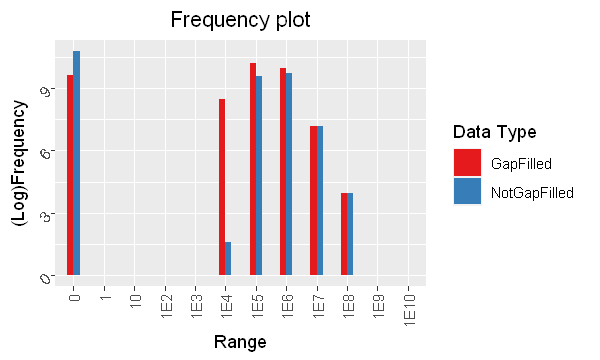

In [31]:
if(readline('Do you want to perform Imputation with minimum value of NonGapFilled table? - Y/N:')=='Y'){
    plot<- FrequencyPlot(GapFilled,NotGapFilled)
    
    Arg1 = plot$data$Condition[1]
    Arg2 = plot$data$Condition[13]
    
    # getting the 2nd minimum value of non-gap filled data. (The first minimum value in the data table is usually zero)
    RawLOD <- round(min(NotGapFilled[NotGapFilled!=min(NotGapFilled)]))
    
    print(paste0("The minimum value greater than 0 for ",Arg1,":", round(min(GapFilled[GapFilled!=min(GapFilled)]))))
    print(paste0("The minimum value greater than 0 for ",Arg2,":", RawLOD))

    Imputed <- GapFilled
    Imputed[Imputed<RawLOD] <- RawLOD # Replacing values<RawLOD with RawLOD
    head(Imputed) 
}

In [ ]:
write.csv(Imputed, file.path(fName,paste0('Imputed_QuantTable_filled_with_MinValue_',RawLOD,'_CutOff_Used_',Cutoff,'.csv')),row.names =TRUE) 

## 2) Imputation with a Cutoff LOD:
<a id="Impute_LOD"></a>

Instead of replacing with the minimum value of nft, we can also only use ft and see the frquency distribution of its features with the frequency plot. The frequency plot shows where the features are present in higher number.

For ex: If until range 10-100, (shown in the figure as 1E2) there are no or very less features, we want to exclude until that range and consider from range (100-1000), or, in other words, '1E3' or '1000' as Cutoff_LOD. This value will be used to replace the zeros as well as all the values lower than Cutoff_LOD in the data table.

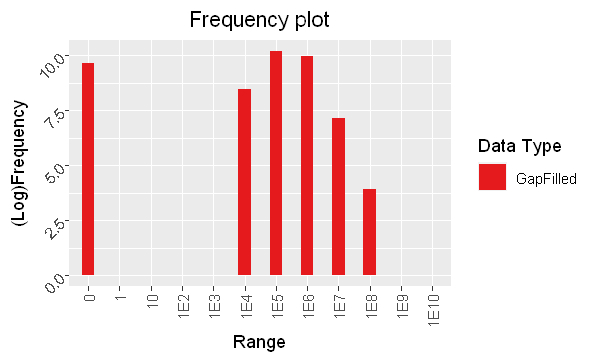

In [32]:
FrequencyPlot(GapFilled,GapFilled)

However, if you are not satisfied with the value as shown in the plot, you can enter any value for imputation. For ex: The minimum value is GapFilled table, which in our case is 1175

In [ ]:
if(readline('Do you want to perform Imputation with a Cutoff LOD? - Y/N:')=='Y'){
    Cutoff_LOD <-as.numeric(readline("Enter your Cutoff LOD as seen in the plot or your value for imputation:"))  #Enter the LOD value as seen in the frequency plot
    Imputed <- GapFilled
    Imputed[Imputed <Cutoff_LOD] <- Cutoff_LOD
    head(Imputed)
}

In [ ]:
dim(Imputed)

In [ ]:
write.csv(Imputed,file.path(fName,paste0('Imputed_QuantTable_filled_with_',Cutoff_LOD,'_CutOff_Used_',Cutoff,'_Bsub','.csv')),row.names =TRUE)

In [ ]:
#removing all the rows with only cutoff values:
#Imputed<-Imputed[rowMeans(Imputed)!= Cutoff_LOD,]  

# Step 3:Normalization
The following code performs sample-centric (column-wise) normalisation:

In [33]:
if (readline("Do you want to perform Normalization: Y/N:") == 'Y'){
    #Getting column-wise sums of the input-data
    sample_sum <- colSums(Imputed, na.rm= TRUE, dims = 1)
    
    #Dividing each element of a particular column with its column sum
    Normalized_data <- c()
    for (i in 1:ncol(Imputed)){
        x <- Imputed[,i] / sample_sum[i]
        Normalized_data <- cbind(Normalized_data, x)
    }
    colnames(Normalized_data) <- names(sample_sum)
    
    head(Normalized_data)
} else return(head(Imputed))
  
print(paste('No.of NA values in Normalized data:',sum(is.na(Normalized_data)== TRUE)))

Do you want to perform Normalization: Y/N:Y


,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
725_152.071_3.252,2.219558e-05,2.226123e-05,2.061146e-05,9.000699e-05,9.276998e-05,9.186396e-05,7.055381e-05,6.837225e-05,7.258992e-05,8.776338e-05,9.480339e-05,9.409999e-05,8.496743e-05,1.056235e-04,1.039572e-04
1105_152.107_4.734,2.021995e-04,2.078308e-04,2.018762e-04,3.226568e-05,4.144970e-05,3.634864e-05,4.622075e-05,4.560528e-05,5.167099e-05,2.185747e-05,1.994631e-05,3.015479e-05,1.414227e-05,2.035184e-05,1.685699e-05
21233_153.091_8.525,2.219558e-05,2.226123e-05,2.061146e-05,2.689085e-04,2.866482e-04,2.805729e-04,1.314619e-04,1.345021e-04,1.713807e-04,2.843599e-04,2.554233e-04,3.370306e-04,3.349755e-04,3.605817e-04,3.763604e-04
2431_153.139_5.391,4.933061e-04,5.813153e-04,5.261053e-04,3.506454e-05,5.570745e-05,4.856309e-05,1.166900e-04,1.235714e-04,1.252694e-04,1.249994e-05,1.381950e-05,1.600234e-05,1.258390e-05,1.304918e-05,1.296329e-05
29517_157.101_10.487,2.219558e-05,2.226123e-05,2.061146e-05,8.519323e-05,9.974378e-05,7.962403e-05,1.239027e-04,1.349725e-04,9.989491e-05,9.706728e-05,9.781103e-05,8.715623e-05,8.881491e-05,1.018906e-04,9.427530e-05
1064_158.097_4.708,2.219558e-05,3.650877e-05,4.585130e-05,1.545017e-04,1.671511e-04,2.049931e-04,1.088614e-04,1.210201e-04,1.360192e-04,1.894810e-04,1.798883e-04,2.249046e-04,1.871044e-04,2.339019e-04,1.559884e-04


[1] "No.of NA values in Normalized data: 0"


In [ ]:
dim(Normalized_data)

In [ ]:
write.csv(Normalized_data, file.path(fName,'Normalised_Quant_table.csv'),row.names =TRUE)